In [ ]:
# %pip install openai>1.50.0 langchain>0.3.0 langgraph langchainhub langchain-openai langchain-community langchain-cli langchain_ollama tavily-python>=0.5.0 langchain_nomic nomic[local] langserve faiss-cpu tiktoken pypdf chroma jira google-search-results numexpr beautifulsoup4 scikit-learn

# Research Agent with LangGraph and Ollama


## This notebook implements a research agent that:
 1. Generates search queries
 2. Performs web research
 3. Summarizes findings
 4. Reflects on results to identify knowledge gaps
# We'll use LangGraph for the agent's workflow and Ollama for local LLM inference.


# 1. Setup and Imports

In [1]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = "your-api-key"
# os.environ["TAVILY_API_KEY"] = "your-api-key"
# os.environ["OPENAI_API_KEY"] = 'your-api-key'
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [1]:
import os
import json
from typing import Optional, Any, List
from typing_extensions import Literal, Annotated

from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langchain_ollama import ChatOllama
from langgraph.graph import START, END, StateGraph

# 2. Configuration Model
First, let's define our configuration using Pydantic instead of dataclasses

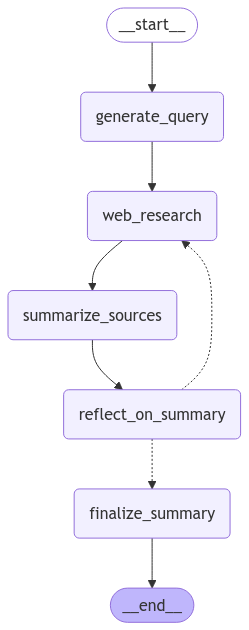

In [4]:
from IPython.display import Image

class Configuration(BaseModel):
    """The configurable fields for the research assistant."""
    max_web_research_loops: int = 3
    local_llm: str = "deepseek-r1"

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            field: os.environ.get(field.upper(), configurable.get(field))
            for field in cls.model_fields.keys()
        }
        return cls(**{k: v for k, v in values.items() if v is not None})

# %% [markdown]
# ## 3. State Models
# Now let's define our state models using Pydantic

# %%
class SummaryState(BaseModel):
    """Main state model for the research agent."""
    research_topic: Optional[str] = None
    search_query: Optional[str] = None
    web_research_results: List[str] = Field(default_factory=list)
    sources_gathered: List[str] = Field(default_factory=list)
    research_loop_count: int = 0
    running_summary: Optional[str] = None

    class Config:
        arbitrary_types_allowed = True

class SummaryStateInput(BaseModel):
    """Input state model."""
    research_topic: Optional[str] = None

class SummaryStateOutput(BaseModel):
    """Output state model."""
    running_summary: Optional[str] = None

# %% [markdown]
# ## 4. Utility Functions
# Let's define our helper functions for web search and source formatting

# %%
from langsmith import traceable
from tavily import TavilyClient

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            char_limit = max_tokens_per_source * 4
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

def format_sources(search_results):
    """Format search results into a bullet-point list of sources."""
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )

@traceable
def tavily_search(query, include_raw_content=True, max_results=3):
    """Search the web using the Tavily API."""
    tavily_client = TavilyClient()
    return tavily_client.search(query, 
                         max_results=max_results, 
                         include_raw_content=include_raw_content)

# %% [markdown]
# ## 5. Agent Prompts
# Define the instruction prompts for our agent's components

# %%
query_writer_instructions = """Your goal is to generate targeted web search query.

The query will gather information related to a specific topic.

Topic:
{research_topic}

Return your query as a JSON object:
{{
    "query": "string",
    "aspect": "string",
    "rationale": "string"
}}
"""

summarizer_instructions = """Your goal is to generate a high-quality summary of the web search results.

When EXTENDING an existing summary:
1. Seamlessly integrate new information without repeating what's already covered
2. Maintain consistency with the existing content's style and depth
3. Only add new, non-redundant information
4. Ensure smooth transitions between existing and new content

When creating a NEW summary:
1. Highlight the most relevant information from each source
2. Provide a concise overview of the key points related to the report topic
3. Emphasize significant findings or insights
4. Ensure a coherent flow of information

CRITICAL REQUIREMENTS:
- Start IMMEDIATELY with the summary content - no introductions or meta-commentary
- Focus ONLY on factual, objective information
- Maintain a consistent technical depth
- Avoid redundancy and repetition
- DO NOT use phrases like "based on the new results" or "according to additional sources"
- DO NOT add a References or Works Cited section
- Begin directly with the summary text
"""

reflection_instructions = """You are an expert research assistant analyzing a summary about {research_topic}.

Your tasks:
1. Identify knowledge gaps or areas that need deeper exploration
2. Generate a follow-up question that would help expand your understanding
3. Focus on technical details, implementation specifics, or emerging trends that weren't fully covered

Ensure the follow-up question is self-contained and includes necessary context for web search.

Return your analysis as a JSON object:
{{ 
    "knowledge_gap": "string",
    "follow_up_query": "string"
}}"""

# %% [markdown]
# ## 6. Agent Nodes
# Define the core functions that make up our agent's workflow

# %%
def generate_query(state: SummaryState, config: RunnableConfig):
    """Generate a query for web search"""
    query_writer_instructions_formatted = query_writer_instructions.format(
        research_topic=state.research_topic
    )
    print("Research topic:")
    print(state.research_topic)

    configurable = Configuration.from_runnable_config(config)
    llm_json_mode = ChatOllama(model=configurable.local_llm, temperature=0, format="json")
    result = llm_json_mode.invoke(
        [SystemMessage(content=query_writer_instructions_formatted),
        HumanMessage(content=f"Given this research topic: {state.research_topic}, generate a query for web search, your output should contain a json with a query key:")]
    )
    print("result")
    print(result)   
    query = json.loads(result.content)
    
    print("Query created in generate_query: ", query)
    
    return {"search_query": query['query']}

def web_research(state: SummaryState):
    """Gather information from the web"""
    print("Current search query", )
    print(state.search_query)
    print(state.research_topic)
    search_results = tavily_search(state.search_query, include_raw_content=True, max_results=1)
    search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000)
    return {
        "sources_gathered": [format_sources(search_results)], 
        "research_loop_count": state.research_loop_count + 1, 
        "web_research_results": [search_str]
    }

def summarize_sources(state: SummaryState, config: RunnableConfig):
    """Summarize the gathered sources"""
    existing_summary = state.running_summary
    most_recent_web_research = state.web_research_results[-1]

    if existing_summary:
        human_message_content = (
            f"Extend the existing summary: {existing_summary}\n\n"
            f"Include new search results: {most_recent_web_research} "
            f"That addresses the following topic: {state.research_topic}"
        )
    else:
        human_message_content = (
            f"Generate a summary of these search results: {most_recent_web_research} "
            f"That addresses the following topic: {state.research_topic}"
        )

    configurable = Configuration.from_runnable_config(config)
    llm = ChatOllama(model=configurable.local_llm, temperature=0)
    result = llm.invoke(
        [SystemMessage(content=summarizer_instructions),
        HumanMessage(content=human_message_content)]
    )

    running_summary = result.content
    return {"running_summary": running_summary}

def reflect_on_summary(state: SummaryState, config: RunnableConfig):
    """Reflect on the summary and generate a follow-up query"""
    configurable = Configuration.from_runnable_config(config)
    llm_json_mode = ChatOllama(model=configurable.local_llm, temperature=0, format="json")
    result = llm_json_mode.invoke(
        [SystemMessage(content=reflection_instructions.format(research_topic=state.research_topic)),
        HumanMessage(content=f"Identify a knowledge gap and generate a follow-up web search query based on our existing knowledge: {state.running_summary}")]
    )   
    follow_up_query = json.loads(result.content)
    query = follow_up_query.get('follow_up_query')
    
    if not query:
        return {"search_query": f"Tell me more about {state.research_topic}"}
    
    return {"search_query": follow_up_query['follow_up_query']}

def finalize_summary(state: SummaryState):
    """Finalize the summary"""
    all_sources = "\n".join(source for source in state.sources_gathered)
    final_summary = f"## Summary\n\n{state.running_summary}\n\n### Sources:\n{all_sources}"
    return {"running_summary": final_summary}

def route_research(state: SummaryState, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    """Route the research based on the follow-up query"""
    configurable = Configuration.from_runnable_config(config)
    if state.research_loop_count <= configurable.max_web_research_loops:
        return "web_research"
    else:
        return "finalize_summary"

# %% [markdown]
# ## 7. Build and Run the Agent
# Now let's put it all together and create our research agent

# %%
# Create the graph
builder = StateGraph(SummaryState, 
                    input=SummaryStateInput, 
                    output=SummaryStateOutput, 
                    config_schema=Configuration)

# Add nodes
builder.add_node("generate_query", generate_query)
builder.add_node("web_research", web_research)
builder.add_node("summarize_sources", summarize_sources)
builder.add_node("reflect_on_summary", reflect_on_summary)
builder.add_node("finalize_summary", finalize_summary)

# Add edges
builder.add_edge(START, "generate_query")
builder.add_edge("generate_query", "web_research")
builder.add_edge("web_research", "summarize_sources")
builder.add_edge("summarize_sources", "reflect_on_summary")
builder.add_conditional_edges("reflect_on_summary", route_research)
builder.add_edge("finalize_summary", END)

# Compile the graph
graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [5]:
# %% [markdown]
# ## 8. Example Usage
# Here's how to use the research agent

# %%
# Example research topic
research_topic = "Write a quick report on the latest LLMs that came out in 2025."

# Run the research agent
config = {"configurable": {"max_web_research_loops": 3, "local_llm": "llama3.2"}}
result = graph.invoke(
    {"research_topic": research_topic},
    config=config
)

Research topic:
Write a quick report on the latest LLMs that came out in 2025.
result
content='{\n    "query": "latest large language models 2025", \n    "aspect": "artificial intelligence", \n    "rationale": "research on new language models"\n}' additional_kwargs={} response_metadata={'model': 'llama3.2', 'created_at': '2025-01-29T19:10:11.491771Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1452616959, 'load_duration': 566169292, 'prompt_eval_count': 139, 'prompt_eval_duration': 192000000, 'eval_count': 39, 'eval_duration': 375000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run-2078baa3-9fd6-446a-be41-390b9f6c8ee1-0' usage_metadata={'input_tokens': 139, 'output_tokens': 39, 'total_tokens': 178}
Query created in generate_query:  {'query': 'latest large language models 2025', 'aspect': 'artificial intelligence', 'rationale': 'research on new language models'}
Current search query
latest large language models 2025
Write a quick re

In [7]:
from IPython.display import Markdown

Markdown(result["running_summary"])

## Summary

Here is an extended version of the summary:

The top 9 large language models (LLMs) as of January 2025 have surpassed 175 billion parameters, with the Command R+ model boasting an industry-leading 128,000 token context window for enhanced long-form processing and multi-turn conversation capabilities. The latest models are highly efficient at processing and generating large amounts of data.

The list highlights the top LLMs in various areas such as natural language processing, code synthesis, few-shot learning, and scalability. The top 9 LLMs include:

1. GPT
2. Command R+
3. Other notable models (not specified)

These models are expected to revolutionize content generation and have significant implications for industries such as healthcare, finance, and education.

The rapid evolution of AI is described as "explosive," with the large language model market in North America alone expected to reach $105.5 billion by 2030. The goal of this post is to keep users up-to-date with current trends and essential innovations in the field.

Key takeaways:

* The latest LLMs have significantly more parameters than previous models
* Command R+ offers an industry-leading context window for enhanced long-form processing
* These models are highly efficient at processing and generating large amounts of data
* GPT-4 is known for its ability to handle complex tasks like generating detailed reports and solving intricate problems, while ChatGPT is optimized for interactive, conversational experiences

According to a recent article by upGrad, the differences between GPT-4 and ChatGPT are significant. GPT-4 is designed to generate and understand human-like text with high precision, making it an essential tool for a variety of applications. It offers enhanced capabilities in reasoning, problem-solving, and contextual understanding, making it particularly useful for tasks that require accuracy and complex decision-making.

On the other hand, ChatGPT is a conversational AI model developed by OpenAI, designed primarily for real-time interactions. It excels at understanding and responding to user queries in a natural, dialogue-driven manner, making it ideal for applications such as customer service, virtual assistants, and interactive chatbots.

In conclusion, the latest LLMs are expected to have a significant impact on industries such as healthcare, finance, and education. Understanding the differences between GPT-4 and ChatGPT is essential for deciding which model suits specific needs. Whether you're looking for a tool to assist with professional projects or improve customer interactions, knowing their strengths is crucial.

Here are some key features of GPT-4:

* Enhanced capabilities in reasoning, problem-solving, and contextual understanding
* Ability to analyze large volumes of data and provide detailed insights
* Creates text that is coherent and contextually relevant

And here are some key features of ChatGPT:

* Designed primarily for real-time interactions
* Excels at understanding and responding to user queries in a natural, dialogue-driven manner
* Ideal for applications such as customer service, virtual assistants, and interactive chatbots.

Furthermore, constructing and training large language models require significant computational resources and large datasets [9], which escalate research and development costs and constrain the applicability and generalization of LLMs. Optimization algorithms are crucial in developing LLMs, enabling researchers to efficiently tailor and refine model structures for specific applications.

Additionally, a recent study published on ScienceDirect highlights the importance of optimization techniques in large language models. The article "When large language model meets optimization" explores the challenges of optimizing large language models and provides insights into the latest advancements in this field [1].

Overall, the latest LLMs are expected to revolutionize content generation and have significant implications for industries such as healthcare, finance, and education.

Sources:

[1] ScienceDirect: When large language model meets optimization
https://www.sciencedirect.com/science/article/pii/S2210650224002013

[9] upGrad: GPT-4 vs ChatGPT - What's the difference?

Note: The full source content from ScienceDirect is limited to 1000 tokens, so only a brief summary of the article is included.

### Sources:
* When large language model meets optimization - ScienceDirect : https://www.sciencedirect.com/science/article/pii/S2210650224002013